# 1. Load Data

-----

In [1]:
!pip install kagglehub[pandas-datasets]
!pip install pandas as pd
!pip install numpy as np
!pip install matplotlib as plt
!pip install seaborn

ERROR: Could not find a version that satisfies the requirement as (from versions: none)
ERROR: No matching distribution found for as
ERROR: Could not find a version that satisfies the requirement as (from versions: none)
ERROR: No matching distribution found for as
ERROR: Could not find a version that satisfies the requirement as (from versions: none)
ERROR: No matching distribution found for as


- Import the location of the dataset posted on Kaggle:
https://www.kaggle.com/datasets/jonassouza872/vitoria-da-conquista-weather-data-september

In [2]:
import kagglehub
import os
# Store the path of the Kaggle dataset
path = kagglehub.dataset_download("jonassouza872/vitoria-da-conquista-weather-data-september")
# Check if the path is correct
print(path)

# List all files inside the downloaded folder
print(os.listdir(path))

100%|██████████| 1.54M/1.54M [00:00<00:00, 23.9MB/s]

Extracting files...


/root/.cache/kagglehub/datasets/jonassouza872/vitoria-da-conquista-weather-data-september/versions/1
['temp.csv']


In [3]:
import pandas as pd
df = pd.read_csv(f"{path}/temp.csv")  # Reads the declared path as a CSV file
df.head()  # Prints the first 5 rows of the dataset

,Timestamp,Temp_MPU6050_C,Temp_AHT20_C,Umid_AHT20_pct,Temp_BMP280_C,Press_BMP280_hPa,Temp_BMP180_C,Press_BMP180_hPa,Temp_DS18B20_C,Temp_NTC_C,Temp_DHT11_C,Umid_DHT11_pct
0,2025-08-31 22:31:02,20.86,19.90,73.37,21.28,921.24,20.19,923.02,25.69,22.26,20.03,66.0
1,2025-08-31 22:31:33,21.75,19.97,75.57,21.48,921.12,20.27,923.04,23.81,20.73,20.02,66.0
2,2025-08-31 22:32:05,21.80,19.75,74.31,21.25,921.20,20.16,923.06,22.50,20.88,20.02,67.0
3,2025-08-31 22:32:36,21.57,19.55,74.77,21.07,921.15,20.06,922.99,21.31,20.62,20.01,66.0
4,2025-08-31 22:33:07,21.66,19.60,75.09,21.12,921.25,20.06,923.02,21.88,20.95,20.00,66.0


In [4]:
df.columns #all columns

Index(['Timestamp', 'Temp_MPU6050_C', 'Temp_AHT20_C', 'Umid_AHT20_pct',
       'Temp_BMP280_C', 'Press_BMP280_hPa', 'Temp_BMP180_C',
       'Press_BMP180_hPa', 'Temp_DS18B20_C', 'Temp_NTC_C', 'Temp_DHT11_C',
       'Umid_DHT11_pct'],
      dtype='object')

# 2. Anomaly detection

---------------

## 2.1. Z-score-based detection

---

- Task: Identify outliers (extreme values) and flag suspicious readings. Visualize the distribution of anomalies.

The Z-score measures how many standard deviations a data point is away from the mean, calculated as Z = (x - μ)/σ. In anomaly detection, values with |Z| > 3 are typically considered outliers, as they represent extremely rare observations in normal distributions. This method assumes data follows a Gaussian distribution and is sensitive to extreme outliers that can distort the mean and standard deviation. It is a simple and computationally efficient technique, ideal for univariate detection in data that meets the normality assumption.

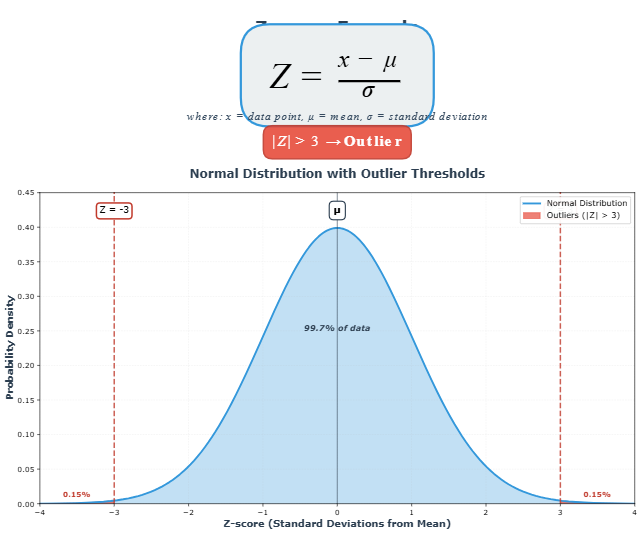

### 2.1.1. Temperature

-------------------

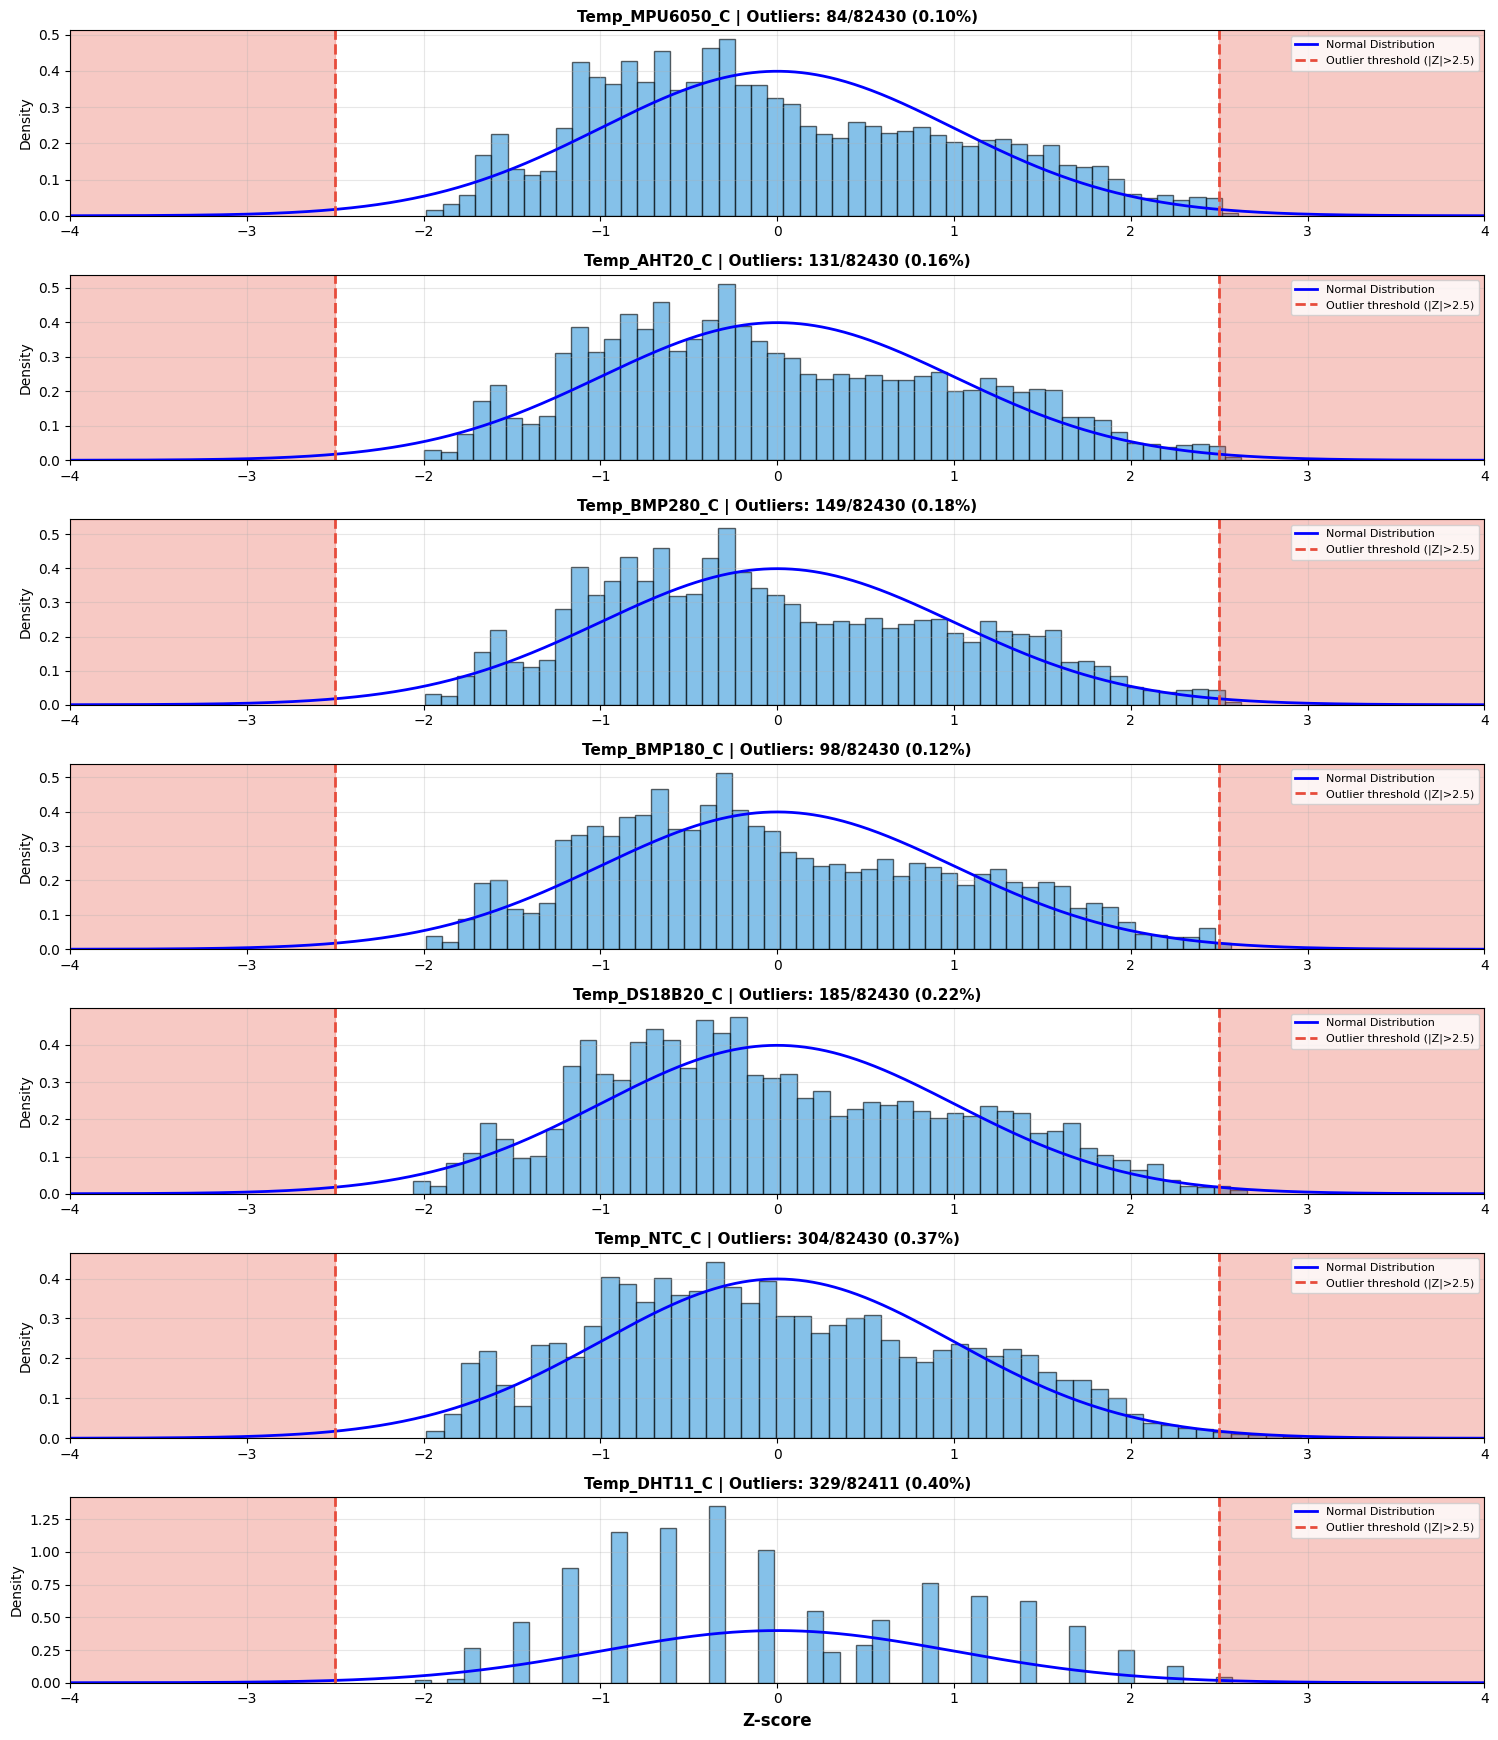

In [11]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats

temp_sensors = ['Temp_MPU6050_C', 'Temp_AHT20_C', 'Temp_BMP280_C', 'Temp_BMP180_C',
                'Temp_DS18B20_C', 'Temp_NTC_C', 'Temp_DHT11_C'] #all temperature sensors

#Subplots
fig, axes = plt.subplots(len(temp_sensors), 1, figsize=(15, 2.5*len(temp_sensors)), sharex=False)
for idx, sensor in enumerate(temp_sensors): #for each sensor
    z_scores = stats.zscore(df[sensor].dropna()) #calculate z_score
    axes[idx].hist(z_scores, bins=50, alpha=0.6, color='#3498DB', edgecolor='black', density=True)# Plot Z-scores histogram
    x = np.linspace(-4, 4, 1000)
    y = (1/np.sqrt(2*np.pi)) * np.exp(-0.5*x**2)
    axes[idx].plot(x, y, 'b-', linewidth=2, label='Normal Distribution')#Adds normal distribution curve.
    axes[idx].axvline(-2.5, color='#E74C3C', linestyle='--', linewidth=2, label='Outlier threshold (|Z|>2.5)') #Outlier region with z_score > 2.5
    axes[idx].axvline(2.5, color='#E74C3C', linestyle='--', linewidth=2)
    axes[idx].axvspan(-4, -2.5, alpha=0.3, color='#E74C3C')
    axes[idx].axvspan(2.5, 4, alpha=0.3, color='#E74C3C')
    n_outliers = np.sum(np.abs(z_scores) > 2.5) #counts the number of points with a threshold greater than 2.5
    total = len(z_scores) #total data

    axes[idx].set_ylabel('Density', fontsize=10)
    axes[idx].set_title(f'{sensor} | Outliers: {n_outliers}/{total} ({100*n_outliers/total:.2f}%)',  #calculates the % of outliers for each sensor. outlier/total
                      fontsize=11, weight='bold')
    axes[idx].legend(loc='upper right', fontsize=8)
    axes[idx].grid(True, alpha=0.3)
    axes[idx].set_xlim(-4, 4)

plt.xlabel('Z-score', fontsize=12, weight='bold')
plt.tight_layout()
plt.show()

Initially, no outliers were detected using the standard threshold of |Z| > 3, indicating that the sensors operate stably and consistently. For a more sensitive analysis, the threshold was reduced to |Z| > 2.5, which flags data points beyond 2.5 standard deviations from the mean—capturing approximately 1.24% of data in a normal distribution compared to only 0.27% with |Z| > 3. This revealed small proportions of outliers: MPU6050 (0.10%), AHT20 (0.16%), BMP280 (0.18%), BMP180 (0.12%), DS18B20 (0.22%), NTC (0.37%), and DHT11 (0.40%). The NTC and DHT11 sensors show the highest outlier rates, suggesting greater variability or sensitivity to noise, while the others maintain excellent conformity with the expected normal distribution. Most distributions closely approximate the theoretical Gaussian curve, confirming the quality and reliability of the collected data.

### 2.1.2. Humidity

---------

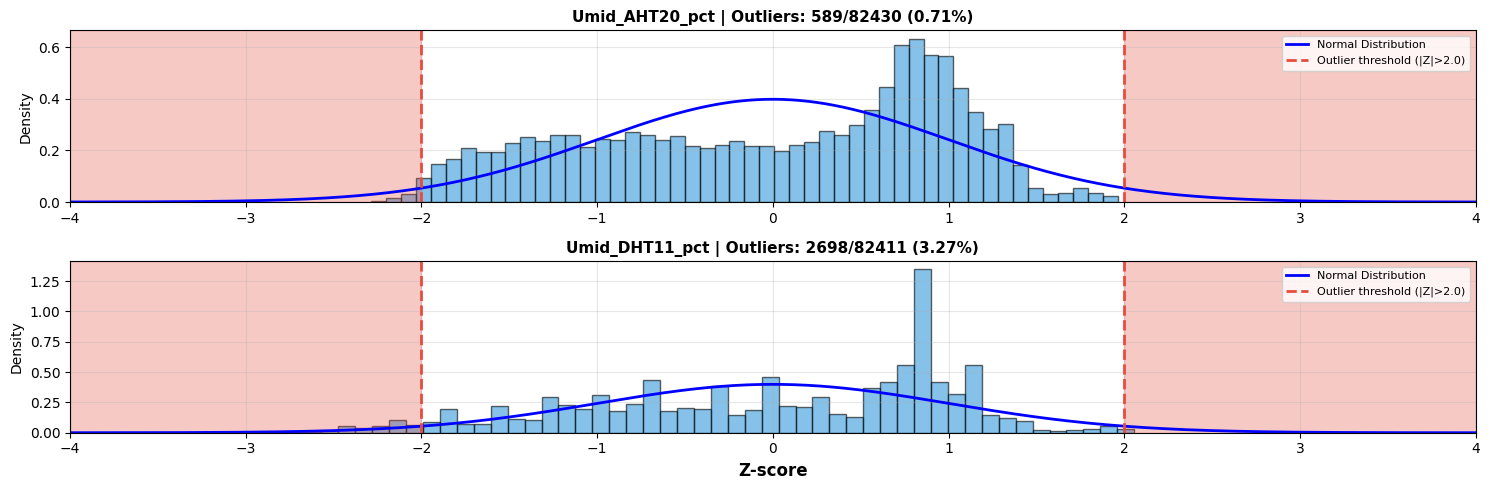

In [19]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats

humidity_sensors = [
    'Umid_AHT20_pct',
    'Umid_DHT11_pct'
] #all humidity sensors

#Subplots
fig, axes = plt.subplots(len(humidity_sensors), 1, figsize=(15, 2.5*len(humidity_sensors)), sharex=False)

# Handle the case of a single sensor (where 'axes' is not an array)
if len(humidity_sensors) == 1:
    axes = [axes]

for idx, sensor in enumerate(humidity_sensors): #for each sensor
    z_scores = stats.zscore(df[sensor].dropna()) #calculate z_score
    axes[idx].hist(z_scores, bins=50, alpha=0.6, color='#3498DB', edgecolor='black', density=True)# Plot Z-scores histogram
    x = np.linspace(-4, 4, 1000)
    y = (1/np.sqrt(2*np.pi)) * np.exp(-0.5*x**2)
    axes[idx].plot(x, y, 'b-', linewidth=2, label='Normal Distribution')#Adds normal distribution curve.
    axes[idx].axvline(-2.0, color='#E74C3C', linestyle='--', linewidth=2, label='Outlier threshold (|Z|>2.0)') #Outlier region with z_score > 2.0
    axes[idx].axvline(2.0, color='#E74C3C', linestyle='--', linewidth=2)
    axes[idx].axvspan(-4, -2.0, alpha=0.3, color='#E74C3C')
    axes[idx].axvspan(2.0, 4, alpha=0.3, color='#E74C3C')
    n_outliers = np.sum(np.abs(z_scores) > 2.0) #counts the number of points with a threshold greater than 2.0
    total = len(z_scores) #total data

    axes[idx].set_ylabel('Density', fontsize=10)
    axes[idx].set_title(f'{sensor} | Outliers: {n_outliers}/{total} ({100*n_outliers/total:.2f}%)',  #calculates the % of outliers for each sensor. outlier/total
                      fontsize=11, weight='bold')
    axes[idx].legend(loc='upper right', fontsize=8)
    axes[idx].grid(True, alpha=0.3)
    axes[idx].set_xlim(-4, 4)

plt.xlabel('Z-score', fontsize=12, weight='bold')
plt.tight_layout()
plt.show()

Due to the absence of outliers with higher thresholds, the limit was reduced to |Z| > 2.0, which captures approximately 4.55% of data in a normal distribution (compared to 1.24% with |Z| > 2.5). The AHT20 sensor showed only 0.71% outliers, demonstrating excellent stability and strong conformity with the expected Gaussian distribution, with data well concentrated near the mean. In contrast, the DHT11 sensor exhibited 3.27% outliers, indicating greater variability and significant deviation from the theoretical normal curve, with a more dispersed and asymmetric distribution. The marked difference between sensors suggests that the DHT11 is more susceptible to noise and environmental fluctuations, while the AHT20 offers more consistent and reliable measurements for humidity monitoring.

### 2.1.3. Pressure

------------------------

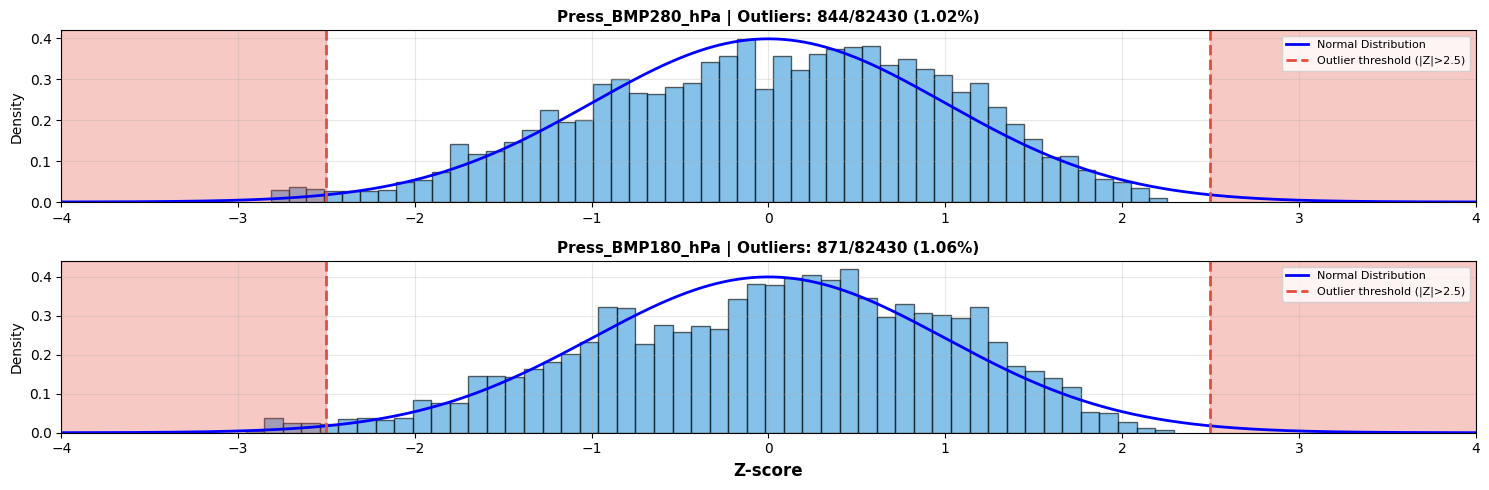

In [18]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats

pressure_sensors = [
    'Press_BMP280_hPa',
    'Press_BMP180_hPa'
] #all pressure sensors

#Subplots
fig, axes = plt.subplots(len(pressure_sensors), 1, figsize=(15, 2.5*len(pressure_sensors)), sharex=False)

# Handle the case of a single sensor (where 'axes' is not an array)
if len(pressure_sensors) == 1:
    axes = [axes]

for idx, sensor in enumerate(pressure_sensors): #for each sensor
    z_scores = stats.zscore(df[sensor].dropna()) #calculate z_score
    axes[idx].hist(z_scores, bins=50, alpha=0.6, color='#3498DB', edgecolor='black', density=True)# Plot Z-scores histogram
    x = np.linspace(-4, 4, 1000)
    y = (1/np.sqrt(2*np.pi)) * np.exp(-0.5*x**2)
    axes[idx].plot(x, y, 'b-', linewidth=2, label='Normal Distribution')#Adds normal distribution curve.
    axes[idx].axvline(-2.5, color='#E74C3C', linestyle='--', linewidth=2, label='Outlier threshold (|Z|>2.5)') #Outlier region with z_score > 2.5
    axes[idx].axvline(2.5, color='#E74C3C', linestyle='--', linewidth=2)
    axes[idx].axvspan(-4, -2.5, alpha=0.3, color='#E74C3C')
    axes[idx].axvspan(2.5, 4, alpha=0.3, color='#E74C3C')
    n_outliers = np.sum(np.abs(z_scores) > 2.5) #counts the number of points with a threshold greater than 2.5
    total = len(z_scores) #total data

    axes[idx].set_ylabel('Density', fontsize=10)
    axes[idx].set_title(f'{sensor} | Outliers: {n_outliers}/{total} ({100*n_outliers/total:.2f}%)',  #calculates the % of outliers for each sensor. outlier/total
                      fontsize=11, weight='bold')
    axes[idx].legend(loc='upper right', fontsize=8)
    axes[idx].grid(True, alpha=0.3)
    axes[idx].set_xlim(-4, 4)

plt.xlabel('Z-score', fontsize=12, weight='bold')
plt.tight_layout()
plt.show()

Both pressure sensors demonstrated exceptional performance with the threshold of |Z| > 2.5, which captures approximately 1.24% of data in a normal distribution. The BMP280 sensor exhibited 1.02% outliers while the BMP180 showed 1.06% outliers, indicating nearly identical and highly stable behavior between both devices. Both distributions closely follow the theoretical Gaussian curve with data well centered around the mean, demonstrating excellent measurement consistency and minimal noise interference. The remarkably similar outlier rates and distribution patterns suggest that both barometric pressure sensors are operating reliably under the same environmental conditions, with no significant calibration drift or sensor-specific anomalies detected during the monitoring period.

## 2.2. Isolation Forest

------------------

Isolation Forest is an anomaly detection algorithm based on decision trees that isolates outliers through random partitions of the data space. The fundamental principle is that anomalies are rare and distinct points, therefore requiring fewer splits (lower tree depth) to be isolated compared to normal points. The algorithm calculates an "anomaly score" for each observation, where values close to 1 indicate anomalies and values close to 0 indicate normal data. It is computationally efficient, does not require data normalization, works well in high dimensions, and detects global anomalies without assuming any specific data distribution.

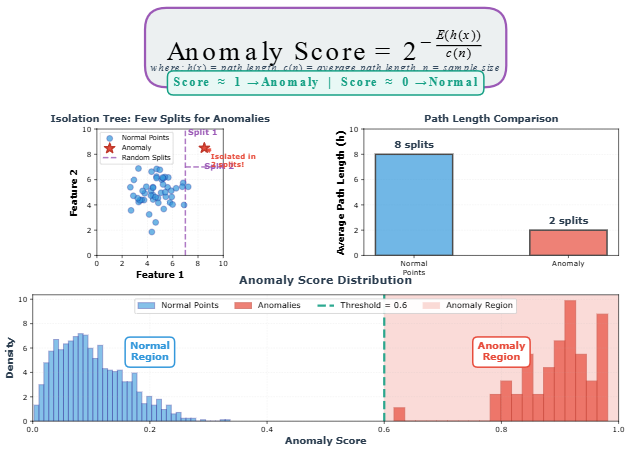

The anomaly score equation s(x, n) = 2^(-E(h(x))/c(n)) normalizes the average path length E(h(x)) of a data point across all isolation trees by dividing it by c(n), the expected path length for a dataset of size n. The normalization factor c(n) = 2H(n-1) - 2(n-1)/n (where H is the harmonic number) represents the average path length of an unsuccessful search in a binary search tree, providing a baseline for comparison. Points with shorter path lengths (isolated quickly) receive scores closer to 1 (anomalies), while points requiring many splits to isolate receive scores closer to 0 (normal points), with scores around 0.5 indicating no clear distinction.